Данный инвестиционный бюллетень показывает наиболее вероятную историческую доходность, которую можно было бы получить инвестируя в российский рынок акций

In [1]:
import datetime
import pandas_datareader
import pandas_datareader.moex as moex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200

# Доходность индекса российского рынка акций
Берем индекс ММВБ, РТС полной доходности брутто: **MCFTR**, **RTSTR**, и строим угловую матрицу доходностей.

In [2]:
# Задаём иследуемый интервал
sdate = datetime.datetime(2006,9,1)
edate = datetime.datetime.today()
print(f'Исследуемый период с {sdate.strftime("%d, %b %Y")} по {edate.strftime("%d, %b %Y")}')

Исследуемый период с 01, Sep 2006 по 27, Aug 2020


In [3]:
#Загружаем историю цен индексов и считаем доходность
stock_indices = ('MCFTR', 'RTSTR')

data = {}
for code in stock_indices:
    data[code] = pandas_datareader.DataReader(code, 'moex', start=sdate, end=edate)

profit = {}
for code in stock_indices:
    end = data[code]['CLOSE'].to_numpy()
    start = end.reshape((end.shape[0], 1))
    profit[code] = (end-start)/start*100

mask = np.zeros_like(profit['MCFTR'])
mask[np.tril_indices_from(mask)] = True

/usr/lib/python3.7/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmap=self.cmap, **kws)


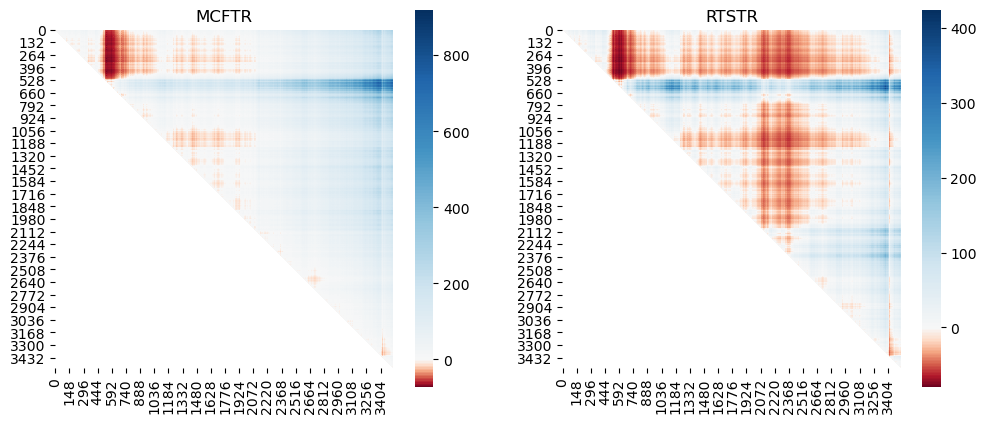

In [4]:
# Отрисовываем тепловую карту доходности для индексов
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
vmin = min(profit['MCFTR'].min(), profit['RTSTR'].min())
vmax = min(profit['MCFTR'].max(), profit['RTSTR'].max())
divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
for i, code in enumerate(stock_indices):
    sns.heatmap(profit[code], square=True, cmap='RdBu', mask=mask, cbar=True, norm=divnorm, ax=axes[i])
    axes[i].set_title(code)

#ax.xaxis.set_major_locator(mdates.YearLocator(1))
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Учет "трения"
Проведённые до этого расчёты достаточно оптимистичны и не учитывают "трение". Далее учтем:
* Издержки на управление портфелем, равные 1% от суммы активов, что соответствует современным ETF и БПИФ, доступных на Московской бирже;
* Комисии на покупку и продажу, равную 0.03% от оборота;
* Налоги с прибыли по ставке 13%, также учтем налоговую льготу для владение бумагами свыше 3-х лет.

In [5]:
# Учет налога с положительного результата инвестирования


# Учет курса валют
А теперь посмотрим как рос российский рынок в [бивалютной карзине](https://ru.wikipedia.org/wiki/%D0%91%D0%B8%D0%B2%D0%B0%D0%BB%D1%8E%D1%82%D0%BD%D0%B0%D1%8F_%D0%BA%D0%BE%D1%80%D0%B7%D0%B8%D0%BD%D0%B0). За основу берем последнее соотношение **0,55 долларов США / 0,45 евро** используемое с 8 февраля 2007 г. (взято с [сайта ЦБРФ](https://www.cbr.ru/archive/db/bicurbase/bicurbacket/))

In [6]:
# Загружаем курс доллара и еврок к рублю и высчитываем стоимость бивалютной корзины
usd_rub = pandas_datareader.DataReader('USD000UTSTOM', 'moex', start=sdate, end=edate)['WAPRICE']
eur_rub = pandas_datareader.DataReader('EUR_RUB__TOM', 'moex', start=sdate, end=edate)['WAPRICE']

# Чистим даные от NaN'ов и нулей
for currency in [usd_rub,eur_rub]:
    currency[currency<1] = np.nan
    currency.fillna(method='ffill', inplace=True)

currency_basket = usd_rub*0.55+eur_rub*0.45

<AxesSubplot:title={'center':'График бивалютной корзины USD+EUR'}, xlabel='Время', ylabel='Условные пункты'>

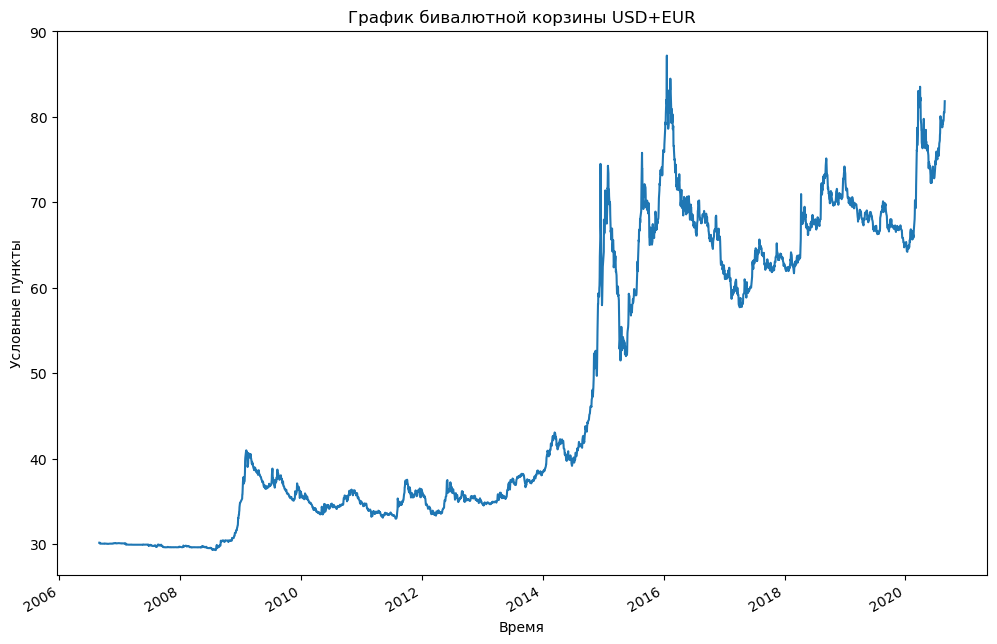

In [7]:
currency_basket.plot(xlabel='Время', ylabel='Условные пункты', title='График бивалютной корзины USD+EUR')